In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

%matplotlib inline

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Mean and Covariance Functions

A large set of mean and covariance functions are available in PyMC.  It is relatively easy to define custom mean and covariance functions.  Since PyMC uses Aesara, their gradients do not need to be defined by the user.  

## Mean functions

The following mean functions are available in PyMC.

- `gp.mean.Zero`
- `gp.mean.Constant`
- `gp.mean.Linear`

All follow a similar usage pattern.  First, the mean function is specified.  Then it can be evaluated over some inputs.  The first two mean functions are very simple.  Regardless of the inputs, `gp.mean.Zero` returns a vector of zeros with the same length as the number of input values.

### Zero

In [3]:
zero_func = pm.gp.mean.Zero()

X = np.linspace(0, 1, 5)[:, None]
print(zero_func(X).eval())

[0. 0. 0. 0. 0.]


The default mean functions for all GP implementations in PyMC is `Zero`.

### Constant

`gp.mean.Constant` returns a vector whose value is provided.

In [4]:
const_func = pm.gp.mean.Constant(25.2)

print(const_func(X).eval())

[25.2 25.2 25.2 25.2 25.2]


As long as the shape matches the input it will receive, `gp.mean.Constant` can also accept a Aesara tensor or vector of PyMC random variables.

In [5]:
const_func_vec = pm.gp.mean.Constant(at.ones(5))

print(const_func_vec(X).eval())

[1. 1. 1. 1. 1.]


### Linear

`gp.mean.Linear` is a takes as input a matrix of coefficients and a vector of intercepts (or a slope and scalar intercept in one dimension).

In [6]:
beta = np.random.randn(3)
b = 0.0

lin_func = pm.gp.mean.Linear(coeffs=beta, intercept=b)

X = np.random.randn(5, 3)
print(lin_func(X).eval())

[-1.50522679  2.48956576  0.0223749  -1.51010979  1.08781069]


## Defining a custom mean function

To define a custom mean function, subclass `gp.mean.Mean`, and provide `__call__` and `__init__` methods.  For example, the code for the `Constant` mean function is

```python
import aesara.tensor as at

class Constant(pm.gp.mean.Mean):
    
    def __init__(self, c=0):
        Mean.__init__(self)
        self.c = c 

    def __call__(self, X): 
        return at.alloc(1.0, X.shape[0]) * self.c

```

Remember that Aesara must be used instead of NumPy.

## Covariance functions

PyMC contains a much larger suite of built-in covariance functions.  The following shows functions drawn from a GP prior with a given covariance function, and demonstrates how composite covariance functions can be constructed with Python operators in a straightforward manner.  Our goal was for our API to follow kernel algebra (see Ch.4 of Rassmussen + Williams) as closely as possible.  See the main documentation page for an overview on their usage in PyMC.

### Exponentiated Quadratic

$$
k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]
$$

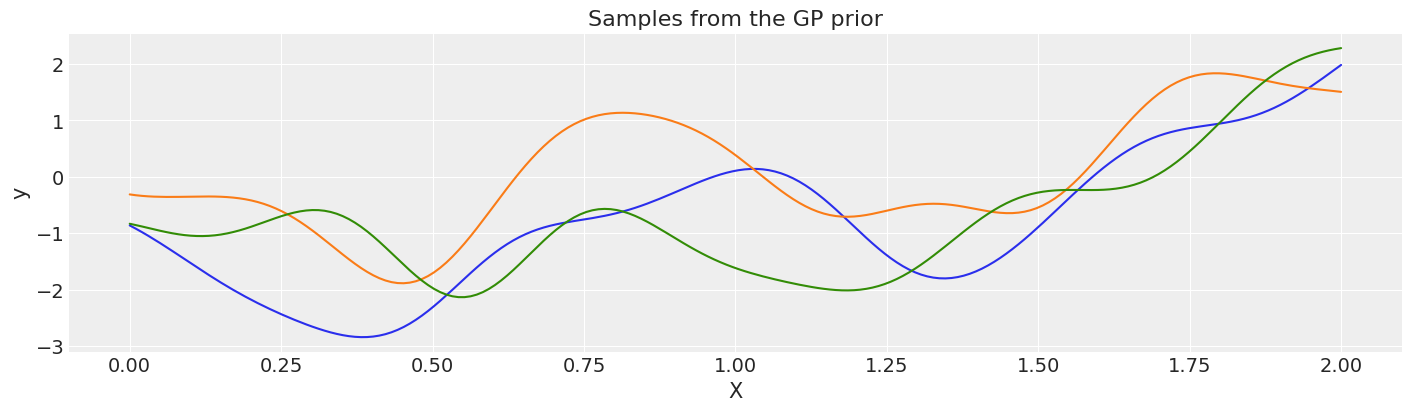

In [7]:
lengthscale = 0.2
eta = 2.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))

plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Two (and higher) Dimensional Inputs

#### Both dimensions active

It is easy to define kernels with higher dimensional inputs.  Notice that the ```ls``` (lengthscale) parameter is an array of length 2.  Lists of PyMC random variables can be used for automatic relevance determination (ARD).

/tmp/ipykernel_8613/269309208.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m);


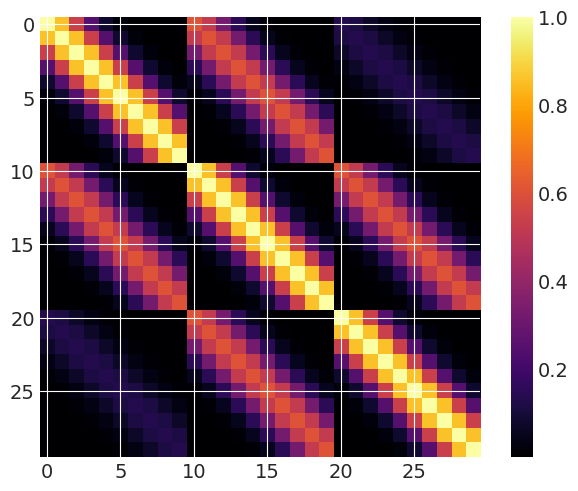

In [8]:
x1 = np.linspace(0, 1, 10)
x2 = np.arange(1, 4)
# Cartesian product
X2 = np.dstack(np.meshgrid(x1, x2)).reshape(-1, 2)

ls = np.array([0.2, 1.0])
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

m = plt.imshow(cov(X2).eval(), cmap="inferno", interpolation="none")
plt.colorbar(m);

#### One dimension active

/tmp/ipykernel_8613/3567697422.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m);


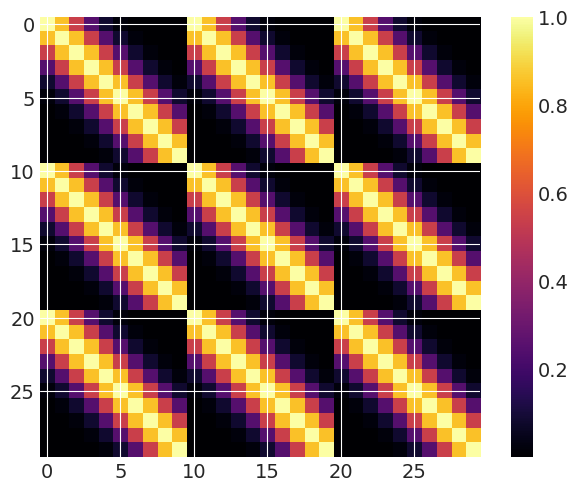

In [9]:
ls = 0.2
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls, active_dims=[0])

m = plt.imshow(cov(X2).eval(), cmap="inferno", interpolation="none")
plt.colorbar(m);

#### Product of covariances over different dimensions

Note that this is equivalent to using a two dimensional `ExpQuad` with separate lengthscale parameters for each dimension.

/tmp/ipykernel_8613/4148738233.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m);


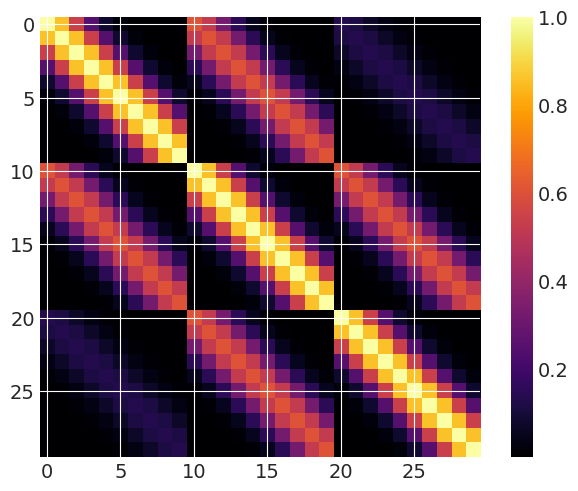

In [10]:
ls1 = 0.2
ls2 = 1.0
cov1 = pm.gp.cov.ExpQuad(2, ls1, active_dims=[0])
cov2 = pm.gp.cov.ExpQuad(2, ls2, active_dims=[1])
cov = cov1 * cov2

m = plt.imshow(cov(X2).eval(), cmap="inferno", interpolation="none")
plt.colorbar(m);

### White Noise

$$
k(x, x') = \sigma^2 \mathrm{I}_{xx}
$$

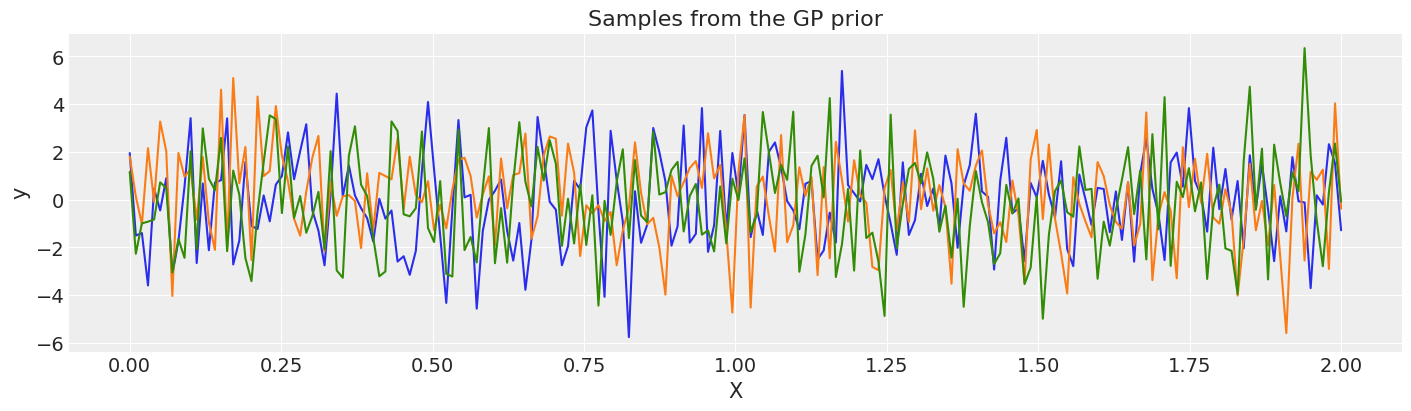

In [11]:
sigma = 2.0
cov = pm.gp.cov.WhiteNoise(sigma)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Constant

$$
k(x, x') = c
$$

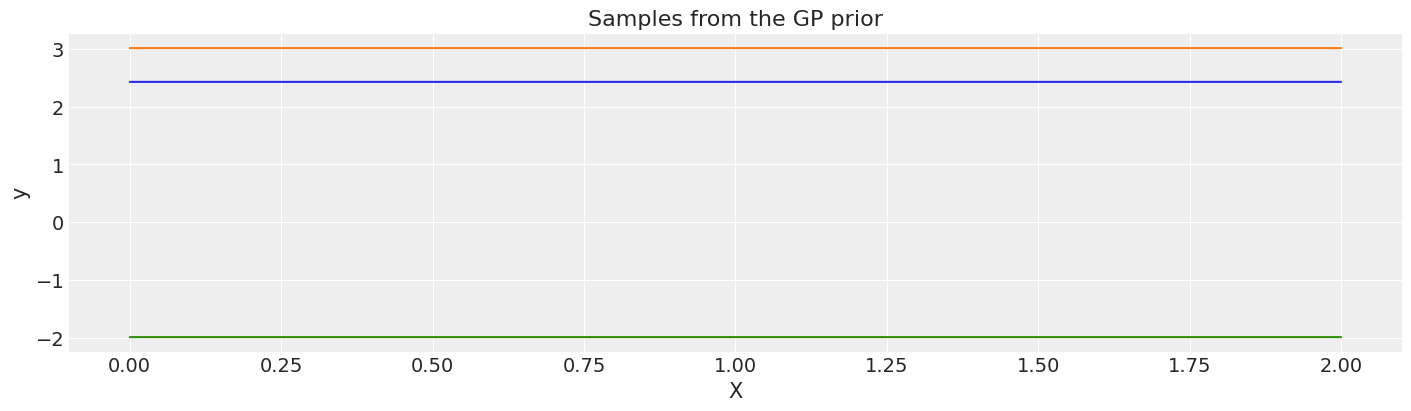

In [12]:
c = 2.0
cov = pm.gp.cov.Constant(c)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Rational Quadratic

$$
k(x, x') = \left(1 + \frac{(x - x')^2}{2\alpha\ell^2} \right)^{-\alpha}
$$

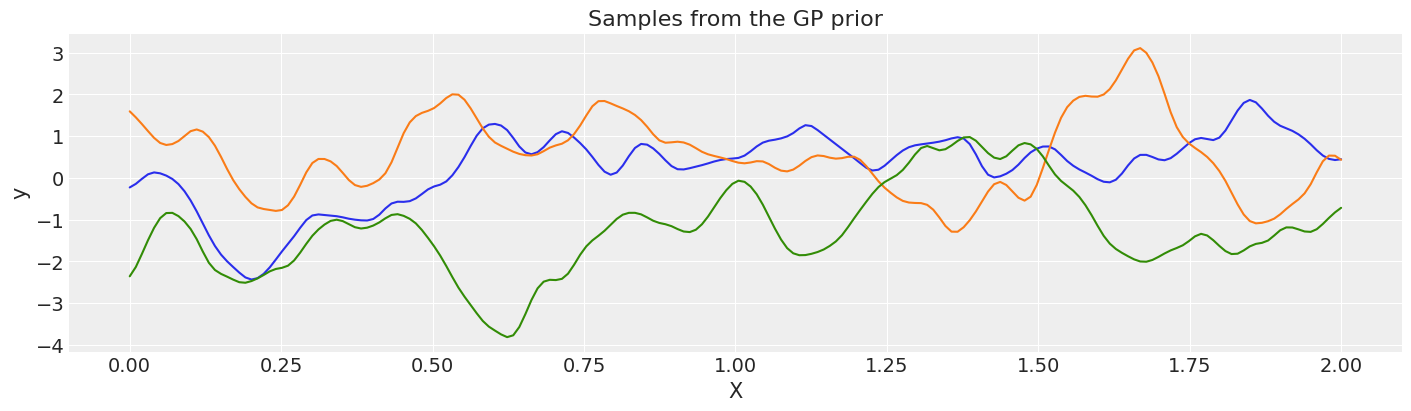

In [13]:
alpha = 0.1
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.RatQuad(1, ls, alpha)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Exponential

$$
k(x, x') = \mathrm{exp}\left[ -\frac{||x - x'||}{2\ell^2} \right]
$$

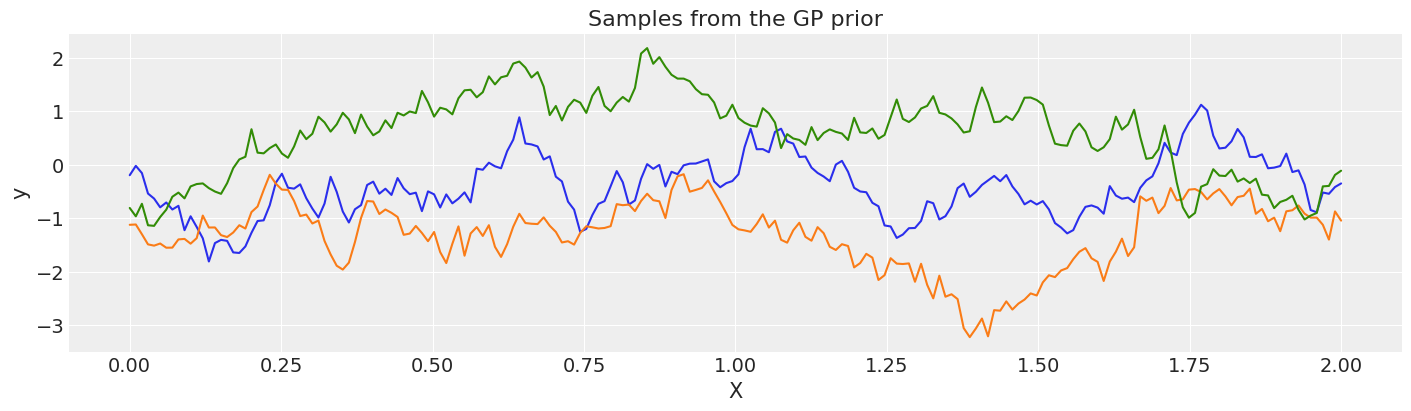

In [14]:
inverse_lengthscale = 5
cov = pm.gp.cov.Exponential(1, ls_inv=inverse_lengthscale)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Matern 5/2

$$
k(x, x') = \left(1 + \frac{\sqrt{5(x - x')^2}}{\ell} +
            \frac{5(x-x')^2}{3\ell^2}\right)
            \mathrm{exp}\left[ - \frac{\sqrt{5(x - x')^2}}{\ell} \right]
$$

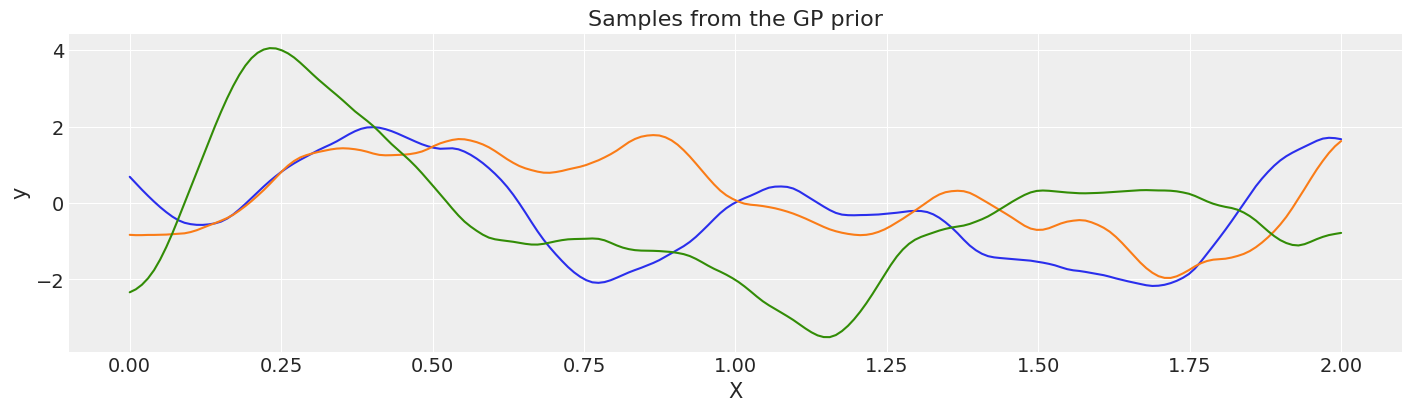

In [15]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern52(1, ls)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Matern 3/2

$$
k(x, x') = \left(1 + \frac{\sqrt{3(x - x')^2}}{\ell}\right)
           \mathrm{exp}\left[ - \frac{\sqrt{3(x - x')^2}}{\ell} \right]
$$

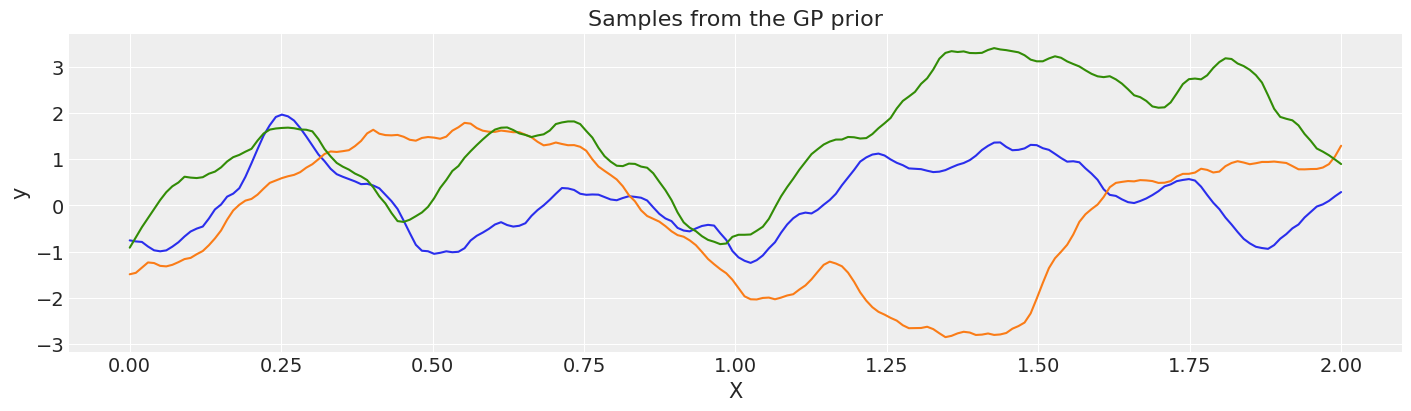

In [16]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern32(1, ls)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Matern 1/2

$$k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{\ell} \right]$$

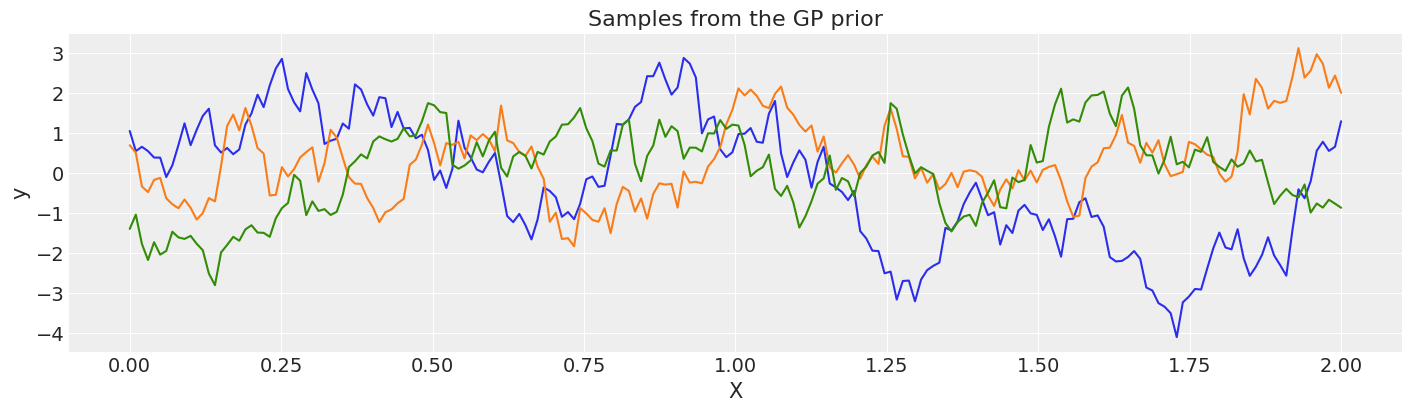

In [17]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern12(1, ls)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Cosine

$$
k(x, x') = \mathrm{cos}\left( 2 \pi \frac{||x - x'||}{ \ell^2} \right)
$$

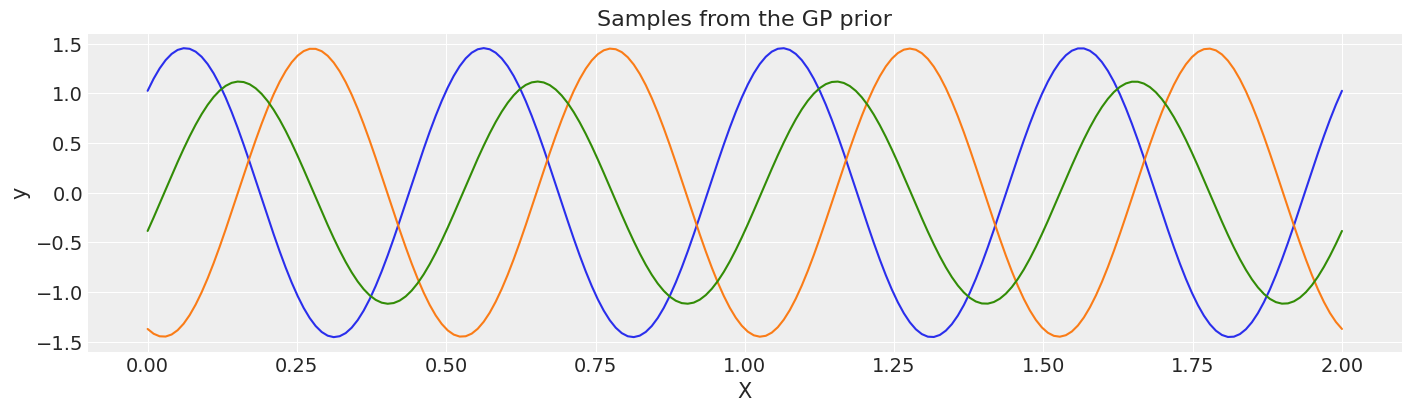

In [18]:
period = 0.5
cov = pm.gp.cov.Cosine(1, period)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-4)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Linear

$$
k(x, x') = (x - c)(x' - c)
$$

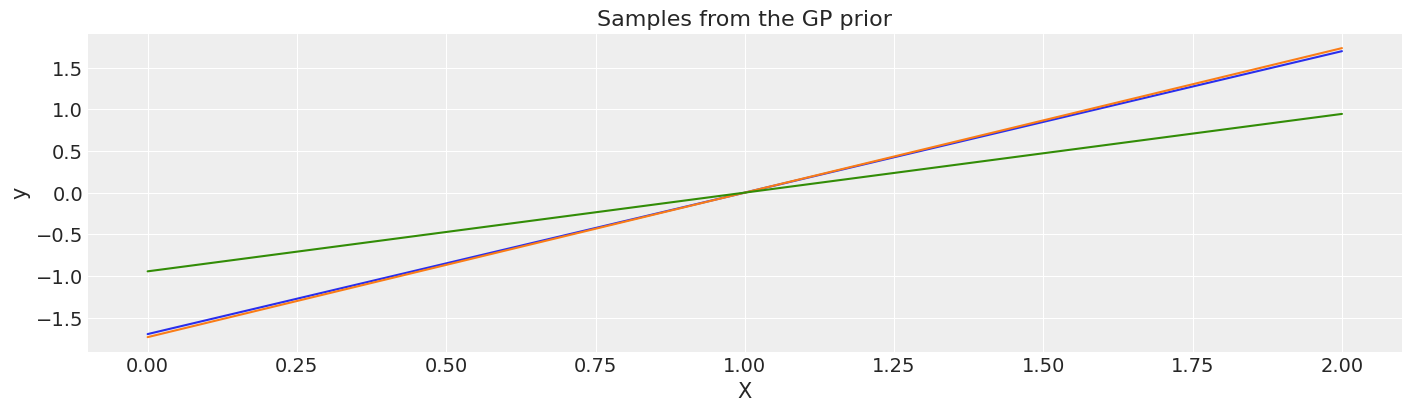

In [19]:
c = 1.0
tau = 2.0
cov = tau * pm.gp.cov.Linear(1, c)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Polynomial

$$
k(x, x') = [(x - c)(x' - c) + \mathrm{offset}]^{d}
$$

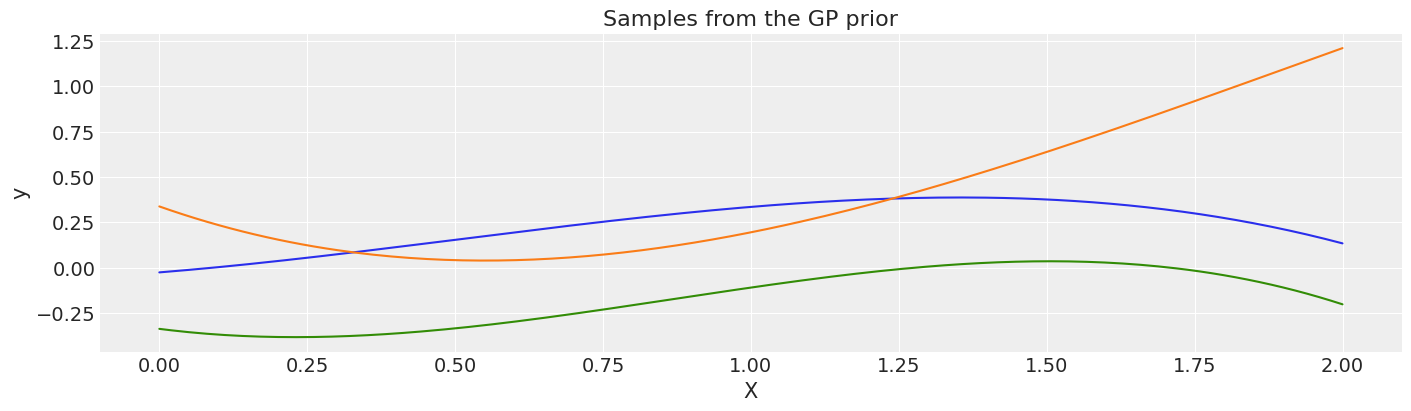

In [20]:
c = 1.0
d = 3
offset = 1.0
tau = 0.1
cov = tau * pm.gp.cov.Polynomial(1, c=c, d=d, offset=offset)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Multiplication with a precomputed covariance matrix

A covariance function ```cov``` can be multiplied with numpy matrix, ```K_cos```, as long as the shapes are appropriate.

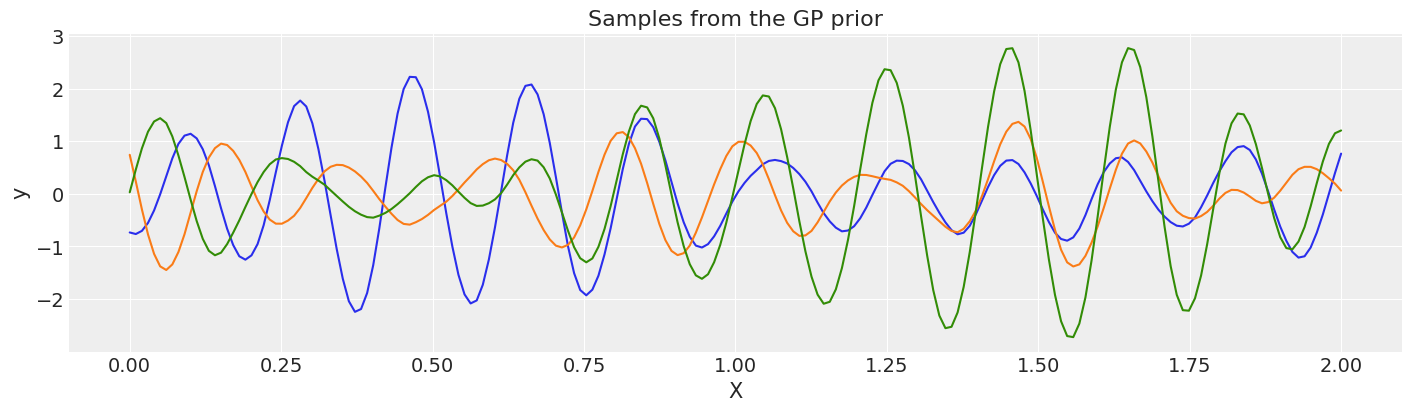

In [21]:
# first evaluate a covariance function into a matrix
period = 0.2
cov_cos = pm.gp.cov.Cosine(1, period)
K_cos = cov_cos(X).eval()

# now multiply it with a covariance *function*
cov = pm.gp.cov.Matern32(1, 0.5) * K_cos

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Applying an arbitary warping function on the inputs

If $k(x, x')$ is a valid covariance function, then so is $k(w(x), w(x'))$.

The first argument of the warping function must be the input ```X```.  The remaining arguments can be anything else, including random variables.

/opt/conda/lib/python3.9/site-packages/pymc/gp/cov.py:95: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


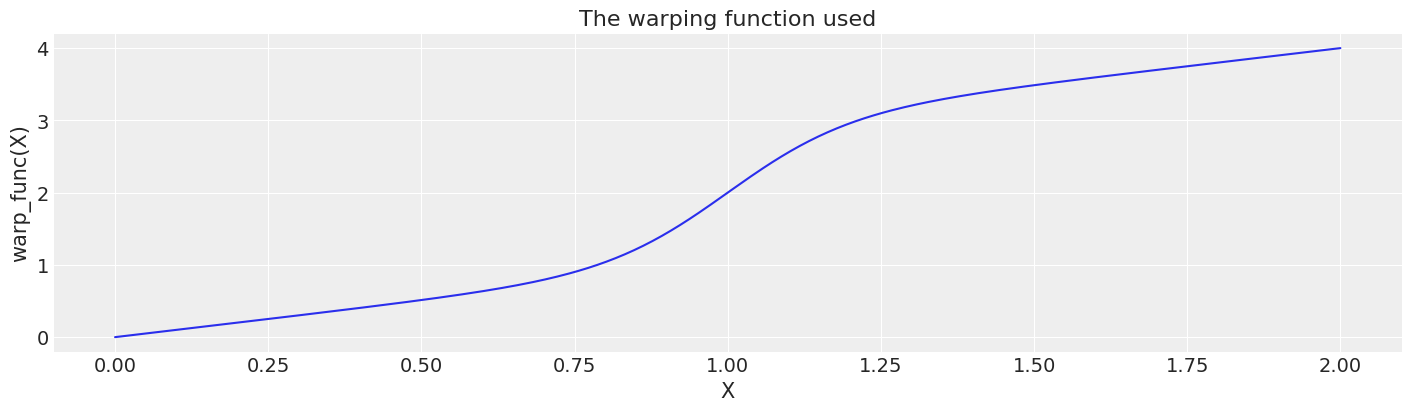

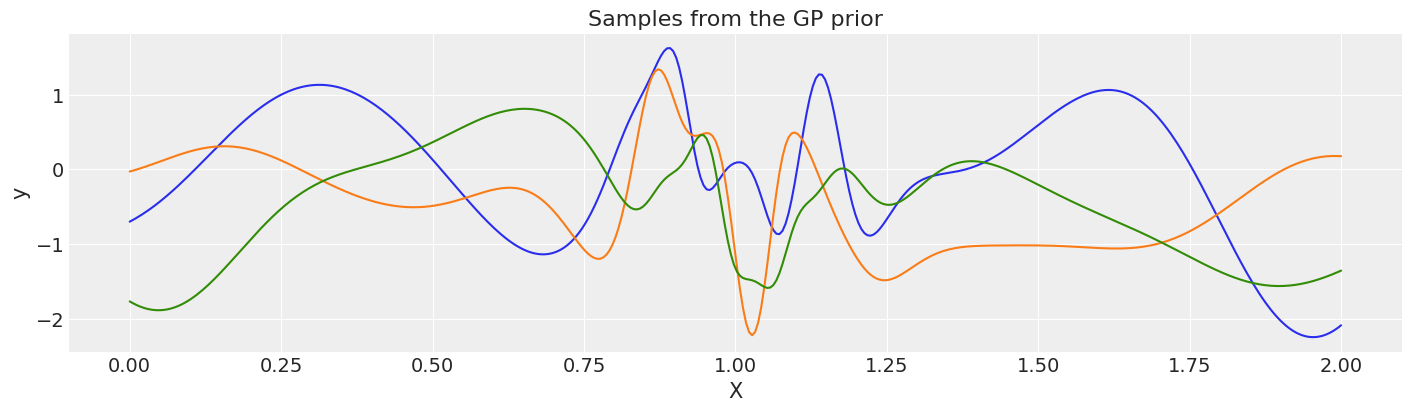

In [22]:
def warp_func(x, a, b, c):
    return 1.0 + x + (a * at.tanh(b * (x - c)))


a = 1.0
b = 5.0
c = 1.0

cov_exp = pm.gp.cov.ExpQuad(1, 0.2)
cov = pm.gp.cov.WarpedInput(1, warp_func=warp_func, args=(a, b, c), cov_func=cov_exp)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 400)[:, None]
wf = warp_func(X.flatten(), a, b, c).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, wf)
plt.xlabel("X")
plt.ylabel("warp_func(X)")
plt.title("The warping function used")

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Constructing `Periodic` using `WarpedInput`

The `WarpedInput` kernel can be used to create the `Periodic` covariance.  This covariance models functions that are periodic, but are not an exact sine wave (like the `Cosine` kernel is).

The periodic kernel is given by

$$
k(x, x') = \exp\left( -\frac{2 \sin^{2}(\pi |x - x'|\frac{1}{T})}{\ell^2}     \right)
$$

Where T is the period, and $\ell$ is the lengthscale.  It can be derived by warping the input of an `ExpQuad` kernel with the function $\mathbf{u}(x) = (\sin(2\pi x \frac{1}{T})\,, \cos(2 \pi x \frac{1}{T}))$.  Here we use the `WarpedInput` kernel to construct it.

The input `X`, which is defined at the top of this page, is 2 "seconds" long.  We use a period of $0.5$, which means that functions
drawn from this GP prior will repeat 4 times over 2 seconds.

/opt/conda/lib/python3.9/site-packages/pymc/gp/cov.py:95: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


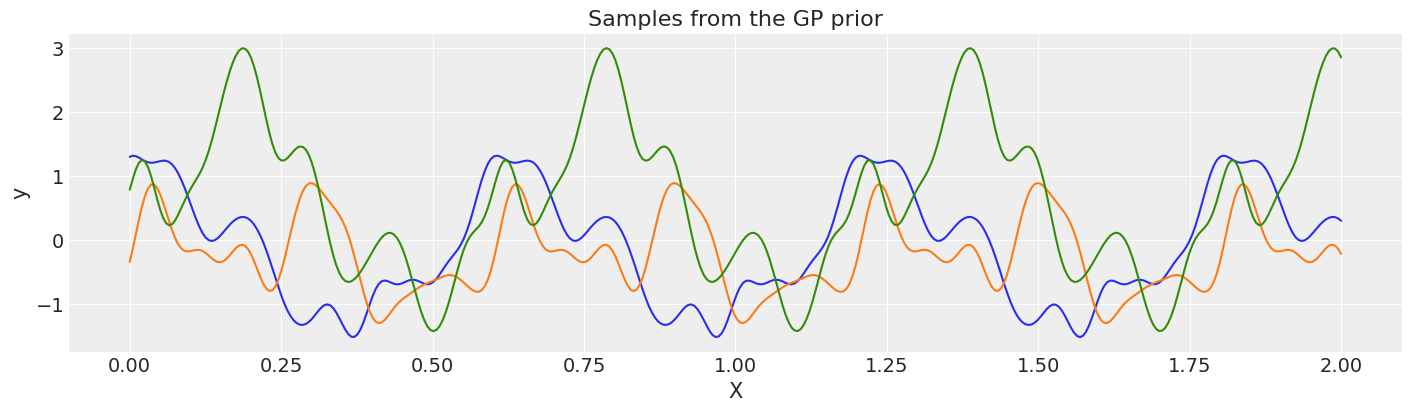

In [23]:
def mapping(x, T):
    c = 2.0 * np.pi * (1.0 / T)
    u = at.concatenate((at.sin(c * x), at.cos(c * x)), 1)
    return u


T = 0.6
ls = 0.4
# note that the input of the covariance function taking
#    the inputs is 2 dimensional
cov_exp = pm.gp.cov.ExpQuad(2, ls)
cov = pm.gp.cov.WarpedInput(1, cov_func=cov_exp, warp_func=mapping, args=(T,))
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Periodic

There is no need to construct the periodic covariance this way every time.  A more efficient implementation of this covariance function is built in.

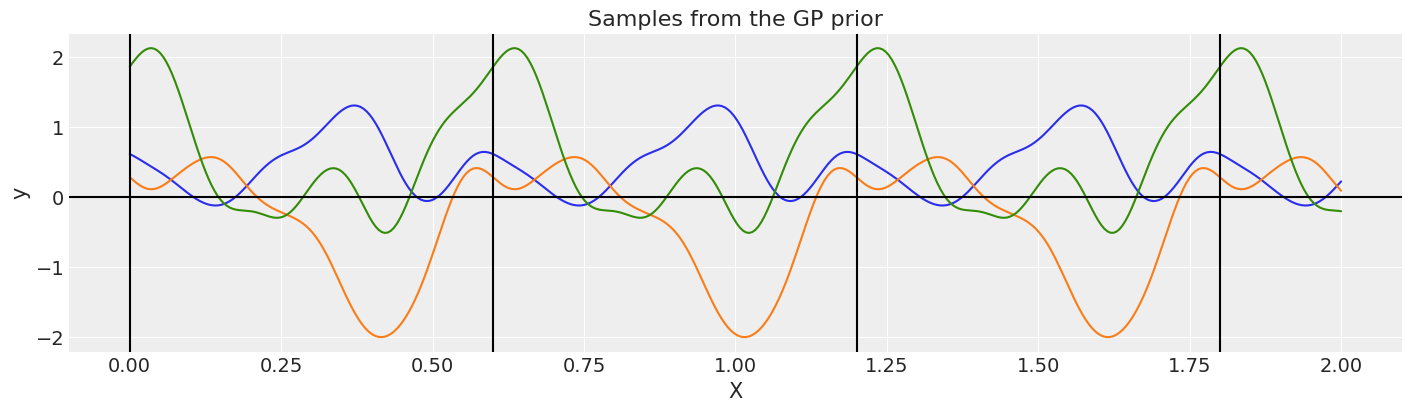

In [24]:
period = 0.6
ls = 0.4
cov = pm.gp.cov.Periodic(1, period=period, ls=ls)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
for p in np.arange(0, 2, period):
    plt.axvline(p, color="black")
plt.axhline(0, color="black")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Circular

Circular kernel is similar to Periodic one but has an additional nuisance parameter $\tau$

In the following [paper](https://hal.archives-ouvertes.fr/hal-01119942v1/document), the Weinland function is used to solve the problem and ensures positive definite kernel on the circular domain (and not only).

$$
W_c(t) = \left(1 + \tau \frac{t}{c}\right)\left(1-\frac{t}{c}\right)_+^\tau
$$
where $c$ is maximum value for $t$ and $\tau\ge 4$ is some positive number 

The kernel itself for geodesic distance (arc length) on a circle looks like

$$
k_g(x, y) = W_\pi(\text{dist}_{\mathit{geo}}(x, y))
$$

Briefly, you can think

* $t$ is time, it runs from $0$ to $24$ and then goes back to $0$
* $c$ is maximum distance between any timestamps, here it would be $12$
* $\tau$ controls for correlation strength, larger $\tau$ leads to less smooth functions

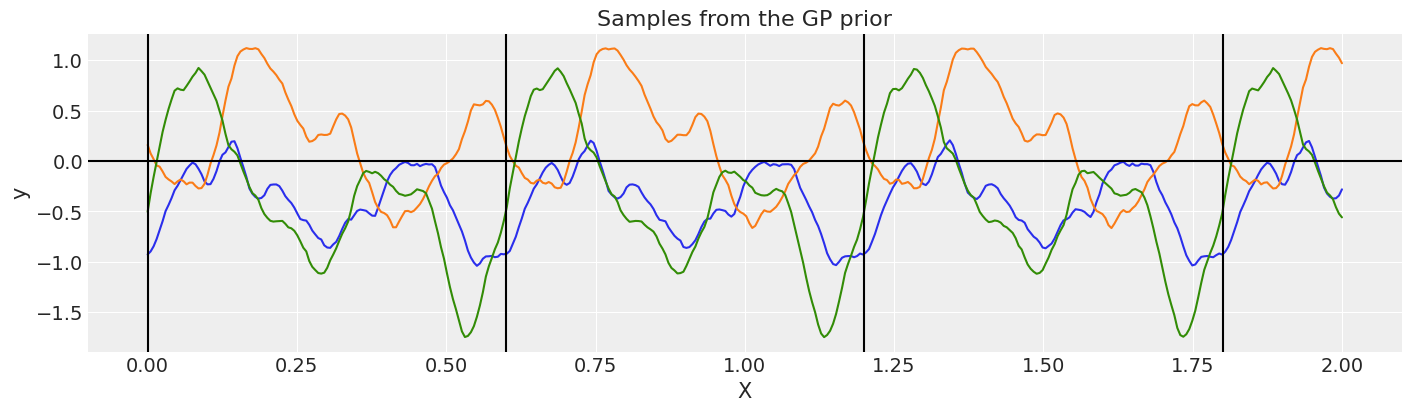

In [25]:
period = 0.6
tau = 4
cov = pm.gp.cov.Circular(1, period=period, tau=tau)

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
for p in np.arange(0, 2, period):
    plt.axvline(p, color="black")
plt.axhline(0, color="black")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

We can see the effect of $\tau$, it adds more non-smooth patterns

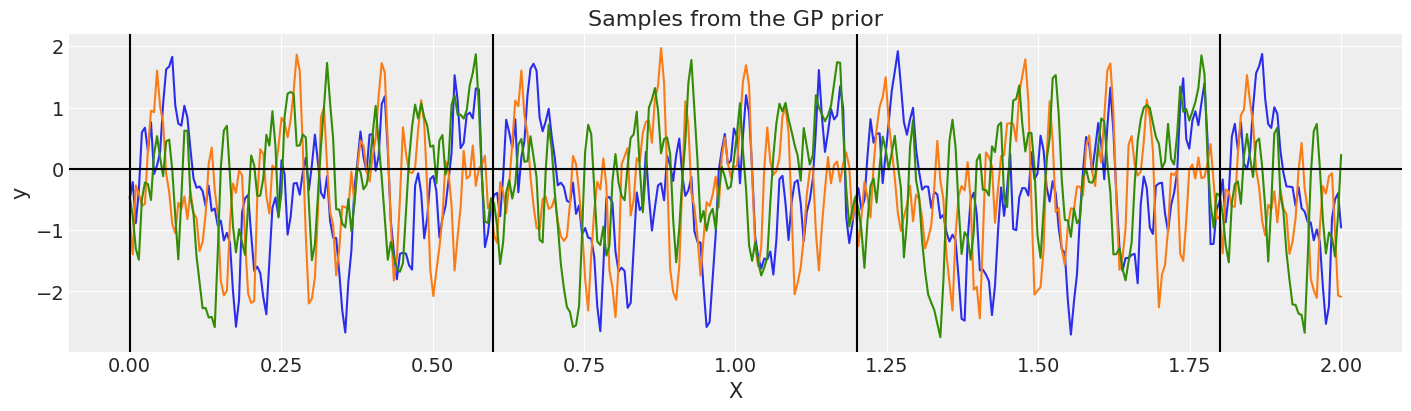

In [26]:
period = 0.6
tau = 40
cov = pm.gp.cov.Circular(1, period=period, tau=tau)

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
for p in np.arange(0, 2, period):
    plt.axvline(p, color="black")
plt.axhline(0, color="black")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Gibbs

The Gibbs covariance function applies a positive definite warping function to the lengthscale.  Similarly to ```WarpedInput```, the lengthscale warping function can be specified with parameters that are either fixed or random variables.

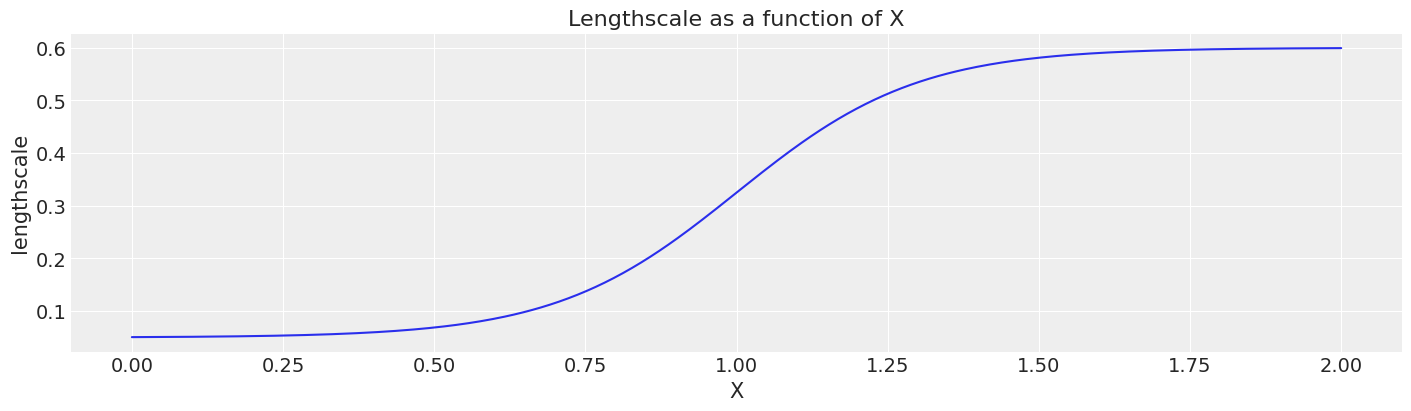

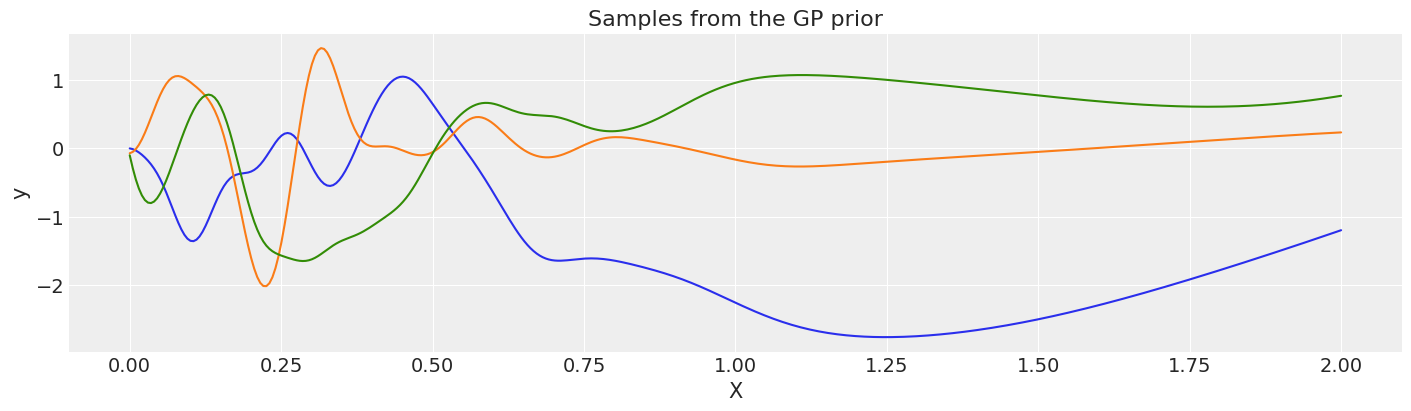

In [27]:
def tanh_func(x, ls1, ls2, w, x0):
    """
    ls1: left saturation value
    ls2: right saturation value
    w:   transition width
    x0:  transition location.
    """
    return (ls1 + ls2) / 2.0 - (ls1 - ls2) / 2.0 * at.tanh((x - x0) / w)


ls1 = 0.05
ls2 = 0.6
w = 0.3
x0 = 1.0
cov = pm.gp.cov.Gibbs(1, tanh_func, args=(ls1, ls2, w, x0))
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

wf = tanh_func(X, ls1, ls2, w, x0).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, wf)
plt.ylabel("lengthscale")
plt.xlabel("X")
plt.title("Lengthscale as a function of X")

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Scaled Covariance

One can construct a new kernel or covariance function by multiplying some base kernel by a nonnegative function $\phi(x)$,

$$
k_{\mathrm{scaled}}(x, x') = \phi(x) k_{\mathrm{base}}(x, x') \phi(x') \,.
$$

This is useful for specifying covariance functions whose amplitude changes across the domain.

/opt/conda/lib/python3.9/site-packages/pymc/gp/cov.py:95: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


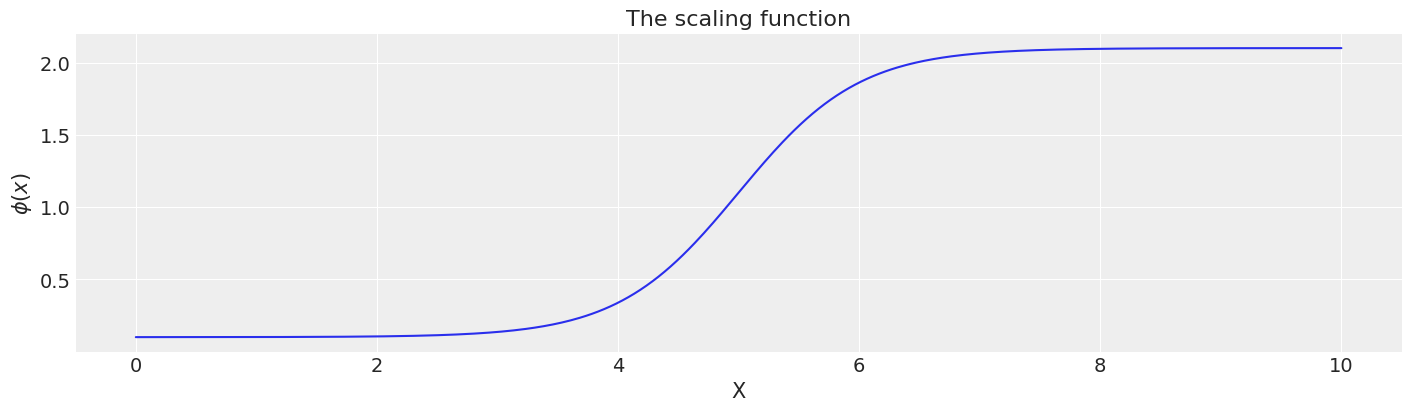

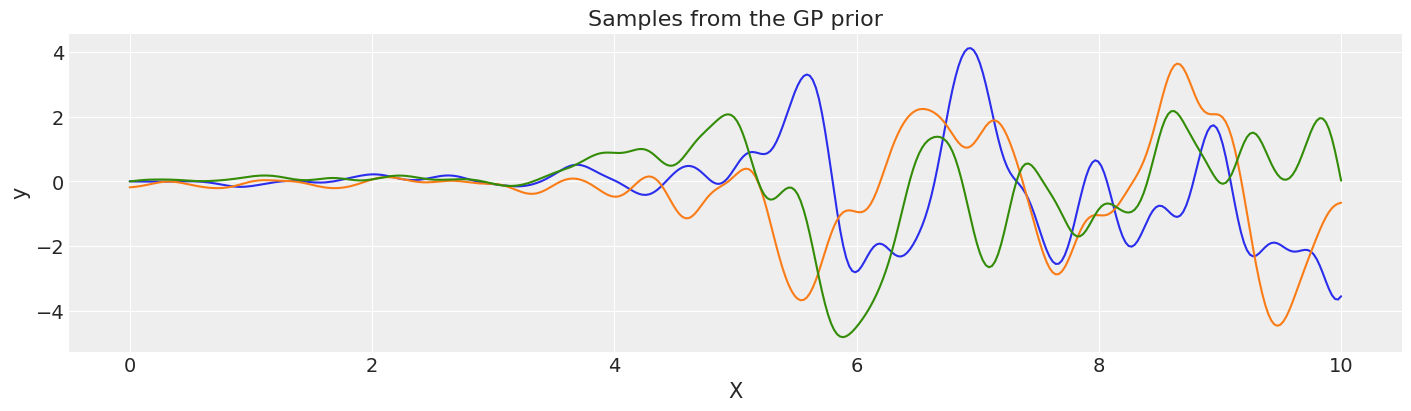

In [28]:
def logistic(x, a, x0, c, d):
    # a is the slope, x0 is the location
    return d * pm.math.invlogit(a * (x - x0)) + c


a = 2.0
x0 = 5.0
c = 0.1
d = 2.0

cov_base = pm.gp.cov.ExpQuad(1, 0.2)
cov = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(a, x0, c, d), cov_func=cov_base)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-5)

X = np.linspace(0, 10, 400)[:, None]
lfunc = logistic(X.flatten(), a, b, c, d).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, lfunc)
plt.xlabel("X")
plt.ylabel(r"$\phi(x)$")
plt.title("The scaling function")

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Constructing a Changepoint kernel using `ScaledCov`

The `ScaledCov` kernel can be used to create the `Changepoint` covariance.  This covariance models 
a process that gradually transitions from one type of behavior to another.

The changepoint kernel is given by

$$
k(x, x') = \phi(x)k_{1}(x, x')\phi(x)  + (1 - \phi(x))k_{2}(x, x')(1 - \phi(x'))
$$

where $\phi(x)$ is the logistic function.

/opt/conda/lib/python3.9/site-packages/pymc/gp/cov.py:95: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


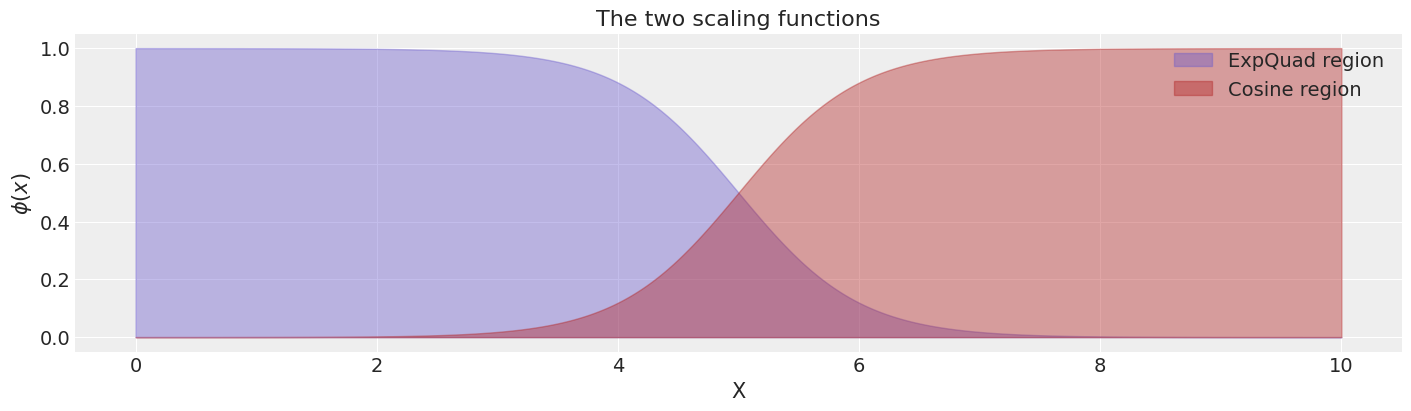

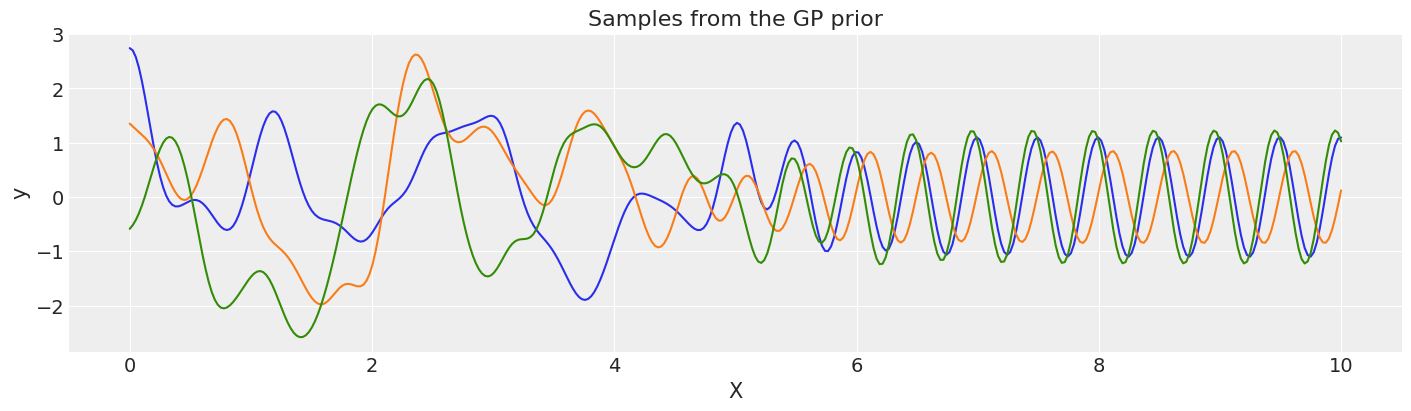

In [29]:
def logistic(x, a, x0):
    # a is the slope, x0 is the location
    return pm.math.invlogit(a * (x - x0))


a = 2.0
x0 = 5.0

cov1 = pm.gp.cov.ScaledCov(
    1, scaling_func=logistic, args=(-a, x0), cov_func=pm.gp.cov.ExpQuad(1, 0.2)
)
cov2 = pm.gp.cov.ScaledCov(
    1, scaling_func=logistic, args=(a, x0), cov_func=pm.gp.cov.Cosine(1, 0.5)
)
cov = cov1 + cov2
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-5)

X = np.linspace(0, 10, 400)
plt.figure(figsize=(14, 4))
plt.fill_between(
    X,
    np.zeros(400),
    logistic(X, -a, x0).eval(),
    label="ExpQuad region",
    color="slateblue",
    alpha=0.4,
)
plt.fill_between(
    X, np.zeros(400), logistic(X, a, x0).eval(), label="Cosine region", color="firebrick", alpha=0.4
)
plt.legend()
plt.xlabel("X")
plt.ylabel(r"$\phi(x)$")
plt.title("The two scaling functions")

K = cov(X[:, None]).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Combination of two or more Covariance functions

You can combine different covariance functions to model complex data.

In particular, you can perform the following operations on any covaraince functions:

- Add other covariance function with equal or broadcastable dimensions with first covariance function
- Multiply with a scalar or a covariance function with equal or broadcastable dimensions with first covariance function
- Exponentiate with a scalar.

#### Addition

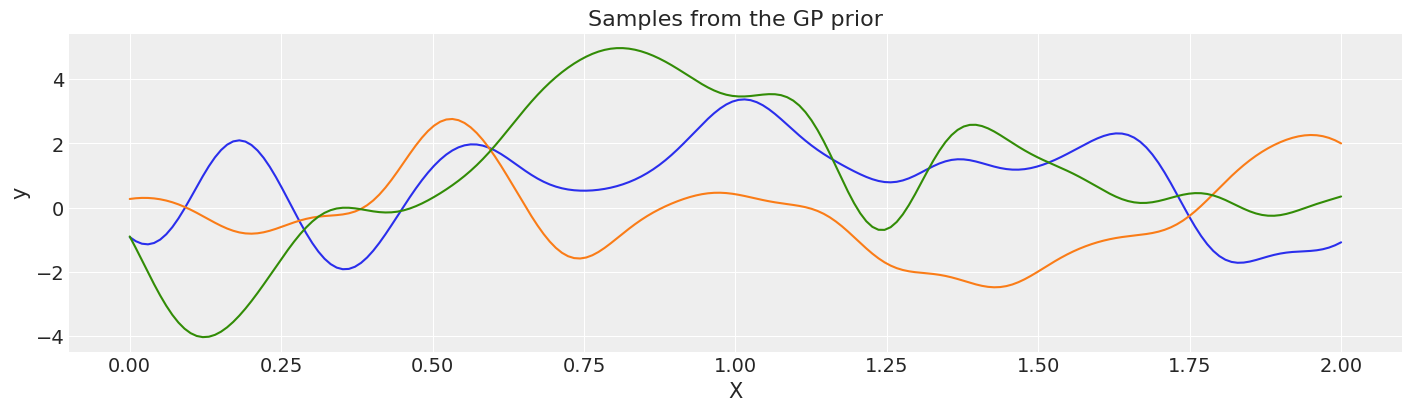

In [30]:
ls_1 = 0.1
tau_1 = 2.0
ls_2 = 0.5
tau_2 = 1.0
cov_1 = tau_1 * pm.gp.cov.ExpQuad(1, ls=ls_1)
cov_2 = tau_2 * pm.gp.cov.ExpQuad(1, ls=ls_2)

cov = cov_1 + cov_2
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

#### Multiplication

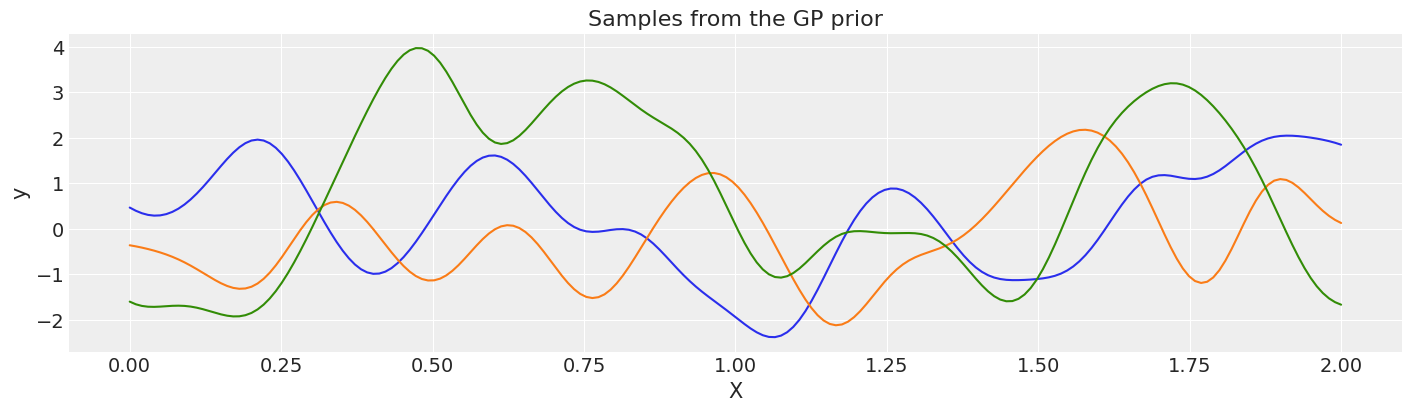

In [31]:
ls_1 = 0.1
tau_1 = 2.0
ls_2 = 0.5
tau_2 = 1.0
cov_1 = tau_1 * pm.gp.cov.ExpQuad(1, ls=ls_1)
cov_2 = tau_2 * pm.gp.cov.ExpQuad(1, ls=ls_2)

cov = cov_1 * cov_2
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

#### Exponentiation

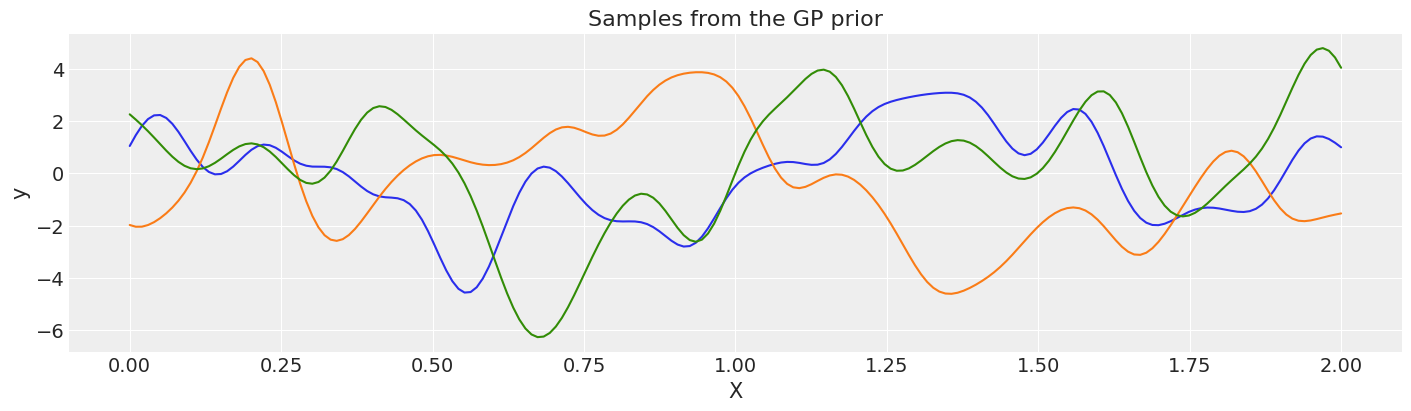

In [32]:
ls_1 = 0.1
tau_1 = 2.0
power = 2
cov_1 = tau_1 * pm.gp.cov.ExpQuad(1, ls=ls_1)

cov = cov_1**power
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, size=3).eval().T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

### Defining a custom covariance function

Covariance function objects in PyMC need to implement the `__init__`, `diag`, and `full` methods, and subclass `gp.cov.Covariance`.  `diag` returns only the diagonal of the covariance matrix, and `full` returns the full covariance matrix.  The `full` method has two inputs `X` and `Xs`.  `full(X)` returns the square covariance matrix, and `full(X, Xs)` returns the cross-covariances between the two sets of inputs.

For example, here is the implementation of the `WhiteNoise` covariance function:

```python
class WhiteNoise(pm.gp.cov.Covariance):
    def __init__(self, sigma):
        super(WhiteNoise, self).__init__(1, None)
        self.sigma = sigma

    def diag(self, X):
        return at.alloc(at.square(self.sigma), X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return at.diag(self.diag(X))
        else:
            return at.alloc(0.0, X.shape[0], Xs.shape[0])
```

If we have forgotten an important covariance or mean function, please feel free to submit a pull request!

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Apr 17 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.2.0

aesara    : 2.5.1
numpy     : 1.22.3
scipy     : 1.8.0
pymc      : 4.0.0b6
arviz     : 0.12.0
matplotlib: 3.5.1

Watermark: 2.3.0

